In [1]:
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import xgboost as xg

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('baltimore-city-employee-salaries-fy2019.csv')
df.columns= df.columns.str.lower()
gross_mean = df.loc[:, 'gross'].mean()

# Заменим пропуски на среднее значение по колонки gross и Дату от которой будем считать стаж
df.loc[:, 'gross'].fillna(gross_mean, inplace=True)
df.loc[:, 'hire_dt'].fillna(datetime(2020, 1, 1), inplace=True)

In [3]:
# Выясним список всех профессий участвующих в выборке
df_jobtitle = df[['jobtitle', 'gross']]
df_jobtitle = df_jobtitle.groupby('jobtitle', as_index=False).mean()
df_jobtitle.describe()
# Видим, что их 1010 уникальных наименований



,gross
count,1010.000000
mean,64389.269835
std,28828.964940
min,1461.540000
25%,45836.290833
50%,60914.598636
75%,77901.222500
max,238772.040000


In [4]:
df_jobtitle.sort_values(by=['gross'], inplace=True)
print(f"Самая низкая средняя зарплата у специалистов: {df_jobtitle.iloc[0]['jobtitle']}\n она составляет: {df_jobtitle.iloc[0]['gross']:.2f}")
print(f"Самая высокая средняя зарплата у специалистов: {df_jobtitle.iloc[-1]['jobtitle']}\n она составляет: {df_jobtitle.iloc[-1]['gross']:.2f}")


Самая низкая средняя зарплата у специалистов: Office Assistant
 она составляет: 1461.54
Самая высокая средняя зарплата у специалистов: State's Attorney
 она составляет: 238772.04


array([[<AxesSubplot:title={'center':'gross'}>]], dtype=object)

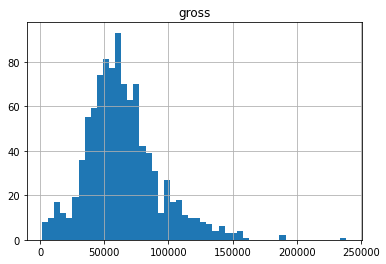

In [5]:
# Гистограмма распределения уровня зарплат по частоте
df_jobtitle.hist(column='gross', bins=50)

In [6]:
# Конвертируем колонку времени устройства в стаж работы (в днях)
convert_point = datetime(2020, 1, 1)
df['hire_dt'] = pd.to_datetime(df['hire_dt'])
work_experience = convert_point - df['hire_dt']
df['work_exp'] = work_experience.dt.days
df.head()


,name,jobtitle,deptid,descr,hire_dt,annual_rt,gross,work_exp
0,"Aaron,Kareem D",Utilities Inst Repair I,A50550,DPW-Water & Waste Water (550),2018-08-27,32470.0,25743.94,492
1,"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev (031),1979-10-24,60200.0,57806.13,14679
2,"Abadir,Adam O",Council Technician,A02002,City Council (002),2016-12-12,64823.0,64774.11,1115
3,"Abaku,Aigbolosimuan O",Police Officer,A99094,Police Department (094),2018-04-17,53640.0,59361.55,624
4,"Abbeduto,Mack",Assistant State's Attorney,A29011,States Attorneys Office (011),2017-05-22,68562.0,61693.59,954


In [7]:
# Обработаем категориальный признак deptid
# Можем заметить, что первые 3 символа - это id департамента, последние - уникальный id сотрудника ( он дублируется в колонке descr )
# Оставим только принадлежность к департаменту и добавим отдельную колонку с id сотрудника

df['eid'] = df['deptid'].str[3:7]
df['deptid'] = df['deptid'].str[:3]
df.head()

,name,jobtitle,deptid,descr,hire_dt,annual_rt,gross,work_exp,eid
0,"Aaron,Kareem D",Utilities Inst Repair I,A50,DPW-Water & Waste Water (550),2018-08-27,32470.0,25743.94,492,550
1,"Aaron,Patricia G",Facilities/Office Services II,A03,OED-Employment Dev (031),1979-10-24,60200.0,57806.13,14679,031
2,"Abadir,Adam O",Council Technician,A02,City Council (002),2016-12-12,64823.0,64774.11,1115,002
3,"Abaku,Aigbolosimuan O",Police Officer,A99,Police Department (094),2018-04-17,53640.0,59361.55,624,094
4,"Abbeduto,Mack",Assistant State's Attorney,A29,States Attorneys Office (011),2017-05-22,68562.0,61693.59,954,011


In [8]:
# подход первый - dummy encoding / one hot encoding

# ohe = OneHotEncoder(sparse=False)
# new_ohe_features = ohe.fit_transform(df.deptid.values.reshape(-1,1))
# tmp = pd.DataFrame(new_ohe_features, columns=[str(i) for i in list(df.deptid.unique())])
# df = pd.concat([df, tmp], axis=1)


In [9]:
# подход второй - label encoding

le = LabelEncoder()
le_deptid = le.fit_transform(df['deptid'].values.reshape(-1,1))
le_jobtitle = le.fit_transform(df['jobtitle'].values.reshape(-1,1))

le_deptid_df = pd.DataFrame(data={'deptid': le_deptid})
le_jobtitle_df = pd.DataFrame(data={'jobtitle': le_jobtitle})

df['deptid'] = le_deptid_df
df['jobtitle'] = le_jobtitle_df

df.head()


/home/nm/Documents/Study/ML/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,name,jobtitle,deptid,descr,hire_dt,annual_rt,gross,work_exp,eid
0,"Aaron,Kareem D",952,30,DPW-Water & Waste Water (550),2018-08-27,32470.0,25743.94,492,550
1,"Aaron,Patricia G",353,2,OED-Employment Dev (031),1979-10-24,60200.0,57806.13,14679,031
2,"Abadir,Adam O",234,1,City Council (002),2016-12-12,64823.0,64774.11,1115,002
3,"Abaku,Aigbolosimuan O",717,48,Police Department (094),2018-04-17,53640.0,59361.55,624,094
4,"Abbeduto,Mack",56,17,States Attorneys Office (011),2017-05-22,68562.0,61693.59,954,011


In [10]:
# Формируем вектор Х и y
# В X войдёт только work_exp и Категориальные признаки
X = df[['jobtitle', 'deptid', 'annual_rt', 'work_exp']]
X.reset_index()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

y = df.loc[:, 'gross'].map(lambda x: x/100000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,jobtitle,deptid,annual_rt,work_exp
13361,0.407787,0.985454,-0.324811,1.114178
9113,-0.041309,0.503432,0.322711,2.564759
12472,0.992385,-2.113260,-0.954733,-0.238132
10066,0.454245,0.227990,-0.471246,-0.768171
8870,-1.179534,-1.011495,0.162538,-0.214661


In [11]:
regressor_l = LinearRegression(n_jobs=-1)
regressor_l.fit(X_train, y_train)

y_pred_test = regressor_l.predict(X_test)


r_sq = regressor_l.score(X_train, y_train)
print('coefficient of determination:', r_sq)
print('Slope: {:.2f}'.format(regressor_l.coef_[0]))
print('Intercept: {:.2f}'.format(regressor_l.intercept_))


coefficient of determination: 0.683398906882825
Slope: 0.02
Intercept: 0.62


In [12]:
mse_test = mean_squared_error(y_test, y_pred_test)
print(f'mse_test: {mse_test:.3f}',)

mse_test: 0.040


In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
regressor_gb = GradientBoostingRegressor(n_estimators=100)
score_gb = cross_val_score(regressor_gb, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1).mean()
print(f"Score: {score_gb:.3f}")

Score: -0.023


In [15]:
regressor_gb.fit(X_train,y_train)
y_pred_test_gb = regressor_gb.predict(X_test)

In [16]:
mse_test_gb=mean_squared_error(y_test, y_pred_test_gb)
print(f"mse_test_gb: {mse_test_gb:.3f}")

mse_test_gb: 0.023


In [17]:
svm_score = {}
kernel_score = {}
C_range = [10.0 ** i for i in range(-3, 2)]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for C in C_range:
    kernel_score = {}
    for kernel in kernels:
        svm = SVR(C=C, kernel=kernel).fit(X_train, y_train)
        y_pred_test_svm = svm.predict(X_test)
        mse_test_svm=mean_squared_error(y_test, y_pred_test_svm)
        kernel_score[kernel] = round(mse_test_svm,3)
        print(f"mse_test_gb: {mse_test_svm:.3f}")
    svm_score[C] = kernel_score
    print(f"Минимальное значение при С = {C} и ядре: {min(kernel_score.items(), key=lambda x: x[1])}")

# Минимальное значение при С = 10.0 и ядре: ('rbf', 0.059)
# Далее искать не стал, т.к. вычисляется долго и значения gb не перебивает.



mse_test_gb: 0.041
mse_test_gb: 0.069


KeyboardInterrupt: 

In [ ]:
regressor_sgb = SGDRegressor(random_state=241).fit(X_train, y_train)
y_pred_test_sgb = regressor_sgb.predict(X_test)
mse_test_sgb=mean_squared_error(y_test, y_pred_test_sgb)
rmse_test_sgb=math.sqrt(mse_test_sgb)
print(f"mse_test_gb: {mse_test_sgb:.3f}")
print(f"mse_test_gb: {rmse_test_sgb:.3f}")

In [ ]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10).fit(X_train, y_train)
y_pred_xgbr = xgb_r.predict(X_test)
mse_test_y_pred_xgbr=mean_squared_error(y_test, y_pred_xgbr)
rmse_test_y_pred_xgbr=math.sqrt(mse_test_y_pred_xgbr)
print(f"mse_test_xgb: {mse_test_y_pred_xgbr:.3f}")
print(f"rmse_test_xgb: {rmse_test_y_pred_xgbr:.3f}")

In [ ]:
d = {'dep':[]}
print(len(d['dep']))